<a href="https://colab.research.google.com/github/anelglvz/Matematicas_Ciencia_Datos/blob/main/Optimizaci%C3%B3n/Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales

Crearemos una red neuronal. Veremos cómo funciona un paso feedforward para después pasar a backpropagation.

Se utilizará la funcion de pérdida de Error Cuadrático Medio, así como funciones de activación distintas (podrá ser ReLu, Sigmoide y Lineal)


<img src='NN.png' width='200' height='200'>

In [1]:
import numpy as np
np.set_printoptions(legacy='1.25')

In [35]:
import matplotlib.pyplot as plt # Ya se importó al inicio
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

### One-hot encoding

In [2]:
# Proceso (manual) para convertir características categóricas en características binarias
def one_hot_encode(y, num_classes):
    y_one_hot = np.zeros((y.shape[0], num_classes))
    idx = [np.arange(y.shape[0]), y]
    y_one_hot[tuple(idx)] = 1
    return y_one_hot

# En pandas, se usa .get_dummies()

Ejemplificando "One Hot Encoding" (ayuda en problemas de clasificación)

In [3]:
# Crea nuevas columnas en la que me dice si el elemento pertenece a la categoría 0, a la 1 o a la 2
encoded = one_hot_encode(np.array([1, 0, 2, 1]), 3)
encoded

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

### Funciones de pérdida
Con las funciones de pérdida, nuestra red neuronal va a poder "aprender"!

El paradigma: **supervisado**

In [4]:
# Nuestra función de perdida (Error cuadrátio medio)
def mse(y_hat, y):
    return np.mean((y - y_hat)**2)

# Derivada de la función de pérdida
def d_mse(y_hat, y):
    return -2 * np.sum(y - y_hat, axis=0) * (1/y_hat.shape[-1]) * (1 / y_hat.shape[0])

In [5]:
uno = np.array([1,2,3,4,5])
dos = np.array([1,2,3,4,7])
mse(uno, dos)

0.8

In [6]:
encoded_hat = np.array([[1., 0., 0.],
                              [1., 0., 0.],
                              [0., 0., 1.],
                              [0., 1., 0.]])

In [7]:
mse(encoded, encoded_hat)

0.16666666666666666

Funciones de activación

In [8]:
def linear(x):
    return x


def d_linear(x):
    return np.ones_like(x)


def relu(x):
    return np.where(x > 0, x, 0)


def d_relu(x):
    return np.where(x > 0, 1, 0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Creación de una Red Neuronal desde cero

Atributos que tendrá nuestra red:

- Pesos (W)
- Sesgos (β)
- Tape (guarda los valores intermedios del feedforward para reutilizarlos en backpropagation)
- Función de activación
- Derivadas de las funciones de activación

Métodos que tendrá:

- __ init __
- forward
- backward
- predict

In [9]:
input_size = 3
hidden_sizes = [3,4]
output_size = 1

In [62]:
# Creación de nuestra clase red, con metodos "forward" para avanzar sobre nuestra red, "backward" para optimizar parámetros, "predict" para lo obvio
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i + 1]
            self.weights.append(np.random.randn(n_in, n_out))
            self.biases.append(np.random.randn(1, n_out))

        self.tape = [None for _ in range(len(layer_sizes))]
        self.activations = [linear] + [relu for _ in range(len(self.weights) - 1)] + [sigmoid]
        self.d_activations = [d_linear] + [d_relu for _ in range(len(self.weights) - 1)] + [d_sigmoid]
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]

    def forward(self, x, grad=False):
        if grad and self.tape[0] is not None:
            raise ValueError("Cannot call forward with grad without calling backwards")

        if grad:
            self.tape[0] = x

        for i in range(len(self.layer_sizes) - 1):
            x_hat = x @ self.weights[i] + self.biases[i]
            x = self.activations[i + 1](x_hat)
            if grad:
                self.tape[i + 1] = x_hat

        return x

    def backward(self, d_loss):
        assert d_loss.shape == self.weights[-1].shape[-1:]

        weights_grad = [None for w in self.weights]
        biases_grad = [None for b in self.biases]

        d_activation = self.d_activations[-1]
        error = d_loss * d_activation(self.tape[-1]) # (n_out) * (n_out)
        error = error.reshape(1, -1)

        for i in reversed(range(len(self.layer_sizes)-1)): 
            x = self.tape[i]
            activation = self.activations[i]
            d_activation = self.d_activations[i]

            weights_grad[i] = error * activation(x.reshape(-1, 1)) # (1, n_out) * (n_in, 1) -> (n_in, n_out) * (n_in, n_out) por broadcast -> (n_in, n_out)
            biases_grad[i] = error * 1 # derivada de los sesgos es un vector de unos, lo representamos explicitamente como 1 (uso de broadcasting)

            error = error @ self.weights[i].T  # (1, n_out) @ (n_out, n_in) -> (1, n_in)
            error = error * d_activation(x).reshape(1, -1) # (1, n_in) * (1, n_in)


        self.tape = [None for _ in range(len(self.weights) + 1)]

        return weights_grad, biases_grad

    def predict(self, x):
        y = self.forward(x)
        preds = np.argmax(y, axis=1) # Funciona para algoritmos de clasificación
        return preds

Para una capa hacia una nueva neurona (léase de izquierda a derecha), calculamos:

$w_1x_1 + w_2x_2+ ... + w_nx_n= y$ 

luego:

$w_1x_1 + w_2x_2+ ... + w_nx_n + β_1 = y$ 

y finalmente:

$f(w_1x_1 + w_2x_2+ ... + w_nx_n + β_1) = y$.

Tendremos una de estas líneas para tantas neuronas haya en la siguiente capa ($y_1, ..., y_m$). Para hacer esta notación más compacta, utilizamos multiplicación de matrices:
$Wx + β = y$,
y, agregando la función de activación:
$f(Wx + β) = y$

<img src='backprop1.png'>

<img src='cr.png'>

# Revisando que la PreAlimentación (Feed Forward) funcione correctamente

In [17]:
# Utilizaremos "assert", el cual regresa un aviso si la condición no se cumple
assert 1 == 2

AssertionError: 

In [24]:
# Revisión
model = NeuralNetwork(2, [4], 1)

inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

targets = np.array([0, 1, 2, 1]).reshape(-1,1)

loss = np.mean((targets - sigmoid(relu(inputs @ model.weights[0] + model.biases[0]) @ model.weights[1] + model.biases[1]))**2)   ## CASO 1 sola intermedia
assert np.isclose(loss, mse(model.forward(inputs), targets))

In [25]:
mse(model.forward(inputs), targets)

1.0242793226524092

# Veamos los atributos de nuestro objeto "model"

In [26]:
model.weights

[array([[ 0.49369434,  0.12045468,  1.07500069, -0.13660522],
        [ 0.52464615,  0.78831111,  0.94212942, -3.27417797]]),
 array([[-0.36603388],
        [-0.69591063],
        [ 0.28956196],
        [-0.32057897]])]

In [27]:
model.biases

[array([[ 0.33267969,  0.81745481,  1.23175252, -0.99363989]]),
 array([[-0.44288547]])]

In [28]:
inputs @ model.weights[0] + model.biases[0]

array([[ 0.33267969,  0.81745481,  1.23175252, -0.99363989],
       [ 0.85732585,  1.60576592,  2.17388194, -4.26781786],
       [ 0.82637403,  0.93790949,  2.3067532 , -1.13024512],
       [ 1.35102018,  1.7262206 ,  3.24888262, -4.40442308]])

In [29]:
model.activations

[<function __main__.linear(x)>,
 <function __main__.relu(x)>,
 <function __main__.sigmoid(x)>]

In [30]:
model.d_activations

[<function __main__.d_linear(x)>,
 <function __main__.d_relu(x)>,
 <function __main__.d_sigmoid(x)>]

# Analytical Gradient

In [32]:
def compute_analytical_gradient(model, X, Y, batch_size, num_classes):
    analytical_weights_grad = [np.zeros(w.shape) for w in model.weights]
    analytical_biases_grad = [np.zeros(b.shape) for b in model.biases]

    batches = list(zip(X, Y))
    for i in range(0, len(batches), batch_size):
        batch = batches[i : i + batch_size]
        x, y = zip(*batch)
        x = np.array(x)
        y = np.array(y)
        y_one_hot = one_hot_encode(y, num_classes) # Solo y cuando no sea problema de clasificación
        y_hat = model.forward(x, grad=True)

        weights_grad, biases_grad = model.backward(d_mse(y_hat, y_one_hot))
        for l in range(len(model.weights)):
            analytical_weights_grad[l] += weights_grad[l]
            analytical_biases_grad[l] += biases_grad[l]

    for l in range(len(model.weights)):
        analytical_weights_grad[l] /= len(X)
        analytical_biases_grad[l] /= len(X)

    return analytical_weights_grad, analytical_biases_grad

Puede que la derivada analítica de mis funciones no exista

In [33]:
# No ES NECESARIA
def compute_numerical_gradient(model, X, Y, batch_size, num_classes, delta=1e-8):
    batches = list(zip(X, Y))

    def compute_loss():
        loss = 0
        for i in range(0, len(batches), batch_size):
            batch = batches[i : i + batch_size]
            x, y = zip(*batch)
            x = np.array(x)
            y = np.array(y)
            y_one_hot = one_hot_encode(y, num_classes)
            y_hat = model.forward(x)
            loss += mse(y_hat, y_one_hot) * len(x)
        return loss / len(X)

    base_loss = compute_loss()

    numerical_weights_grad = [np.zeros(w.shape) for w in model.weights]
    numerical_biases_grad = [np.zeros(b.shape) for b in model.biases]
    for l in range(len(model.weights)):
        for ix, iy in np.ndindex(model.weights[l].shape):
            old_w = model.weights[l][ix][iy]
            new_w = old_w + delta
            model.weights[l][ix][iy] = new_w

            new_loss = compute_loss()
            dL = base_loss - new_loss
            dw = old_w - new_w
            numerical_weights_grad[l][ix][iy] = dL / dw

            model.weights[l][ix][iy] = old_w

        for ii in range(len(model.biases[l][0])):
            old_b = model.biases[l][0][ii]
            new_b = old_b + delta
            model.biases[l][0][ii] = new_b

            new_loss = compute_loss()
            dL = base_loss - new_loss
            db = old_b - new_b
            numerical_biases_grad[l][0][ii] = dL / db

            model.biases[l][0][ii] = old_b

    return numerical_weights_grad, numerical_biases_grad

# Demo interactivo del algoritmo de Backpropagation

In [34]:
input_size = 2
hidden_sizes = [4]
output_size = 1
model = NeuralNetwork(input_size, hidden_sizes, output_size)

n_examples = 1000
n_classes = 1
x = np.random.randn(n_examples, input_size)
y = np.random.randint(0, n_classes, size=(n_examples, n_classes))

numerical_weights_grad, numerical_biases_grad = compute_numerical_gradient(
    model, x, y, batch_size=1, num_classes=n_classes
)
analytical_weights_grad, analytical_biases_grad = compute_analytical_gradient(
    model, x, y, batch_size=1, num_classes=n_classes
)

# check numerical and analytical gradients have same shape
assert len(numerical_weights_grad) == len(analytical_weights_grad) == len(analytical_biases_grad) == len(numerical_biases_grad)
for i in range(len(numerical_weights_grad)):
    assert numerical_weights_grad[i].shape == analytical_weights_grad[i].shape
    assert numerical_biases_grad[i].shape == analytical_biases_grad[i].shape


for l in range(len(model.weights)):
    with np.printoptions(precision=4, suppress=True):
        print(f"---- layer {l} ----")
        print("numerical weights gradient:\n", numerical_weights_grad[l])
        print("analytical weights gradient:\n", analytical_weights_grad[l])
        print()
        print("numerical biases gradient:\n", numerical_biases_grad[l])
        print("analytical biases gradient:\n", analytical_biases_grad[l])
        print()

        if not np.allclose(analytical_weights_grad[l], numerical_weights_grad[l], atol=1e-6):
            print(f"---- layer {l} ----")
            print("numerical weights gradient:\n", numerical_weights_grad[l])
            print("analytical weights gradient:\n", analytical_weights_grad[l])
            raise ValueError("incorrect backprop")

        if not np.allclose(analytical_biases_grad[l], numerical_biases_grad[l], atol=1e-6):
            print(f"---- layer {l} ----")
            print("numerical biases gradient:\n", numerical_biases_grad[l])
            print("analytical biases gradient:\n", analytical_biases_grad[l])
            raise ValueError("incorrect backprop")


---- layer 0 ----
numerical weights gradient:
 [[-0.      0.0014  0.0055 -0.0002]
 [-0.0057 -0.0041  0.0097  0.0001]]
analytical weights gradient:
 [[-0.      0.0014  0.0055 -0.0002]
 [-0.0057 -0.0041  0.0097  0.0001]]

numerical biases gradient:
 [[ 0.013  -0.0033 -0.0192  0.0001]]
analytical biases gradient:
 [[ 0.013  -0.0033 -0.0192  0.0001]]

---- layer 1 ----
numerical weights gradient:
 [[-0.0086]
 [-0.0058]
 [-0.004 ]
 [-0.0001]]
analytical weights gradient:
 [[-0.0086]
 [-0.0058]
 [-0.004 ]
 [-0.0001]]

numerical biases gradient:
 [[-0.0528]]
analytical biases gradient:
 [[-0.0528]]



# Ejemplo con datos "reales"

In [36]:
def generate_area_map(features, points_per_int=10, alpha=0.2):
    xstart = int((features[:, 0].min() - 1) * points_per_int)
    xrang = int((features[:, 0].max() + 1) * points_per_int - xstart)

    ystart = int((features[:, 1].min() - 1) * points_per_int)
    yrang = int((features[:, 1].max() + 1) * points_per_int - ystart)

    area_map_set = np.array(
        [[x + xstart, y + ystart] for x in range(xrang) for y in range(yrang)]
    )
    area_map_set = area_map_set / points_per_int

    return area_map_set


def area_map_plot(network, area_map_set, features, targets, path="", alpha=0.1):
    pred = network.predict(area_map_set)

    plt.scatter(features[:, 0], features[:, 1], c=targets, cmap="jet")
    plt.scatter(area_map_set[:, 0], area_map_set[:, 1], c=pred, alpha=alpha, cmap="jet")

    if path == "":
        plt.show()
    else:
        plt.savefig(path)
        plt.close()


In [37]:
X_all, y_all = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=3,
    center_box=(-1, 1),
    cluster_std=0.25,
    random_state=12345,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25, stratify=y_all
)
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)


X_train shape = (750, 2)
X_test shape = (250, 2)
y_train shape = (750,)
y_test shape = (250,)


In [38]:
X_test

array([[ 0.26556076,  0.16136319],
       [-0.2374254 , -0.59078719],
       [ 0.31513239,  0.0581991 ],
       [ 1.04014256, -0.19474843],
       [-0.8006198 , -0.87613851],
       [ 0.88513573, -0.74117853],
       [-0.52190923, -0.84702939],
       [ 0.30203755,  0.34062298],
       [-0.53707763, -0.85763827],
       [ 0.81235805, -0.49063889],
       [ 1.21317048, -0.22572251],
       [-0.42611998, -0.71317436],
       [ 0.07451312,  0.27144307],
       [-0.01121724,  0.29474306],
       [ 0.68786121, -0.34064106],
       [ 0.47466653, -0.10025706],
       [ 0.40892259, -0.12249026],
       [ 0.9542478 , -0.32000022],
       [ 0.79095922, -0.5009574 ],
       [ 0.77967316, -0.25882065],
       [-0.5819883 , -0.54581537],
       [-0.57779913, -0.59351933],
       [-0.79952145, -0.73257731],
       [ 1.16168468, -0.04974271],
       [-0.583847  , -0.48014836],
       [ 0.10308476,  0.10903183],
       [ 0.28522897,  0.04585713],
       [ 0.08179715,  0.11376054],
       [-0.37586543,

In [39]:
y_test

array([2, 1, 2, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0,
       1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 1,
       2, 2, 2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0,
       1, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 0, 2, 1, 1, 2, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2,
       1, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 2,
       0, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 0, 0, 2, 2,
       1, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0,
       1, 2, 2, 0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1, 2, 1, 1,
       0, 0, 0, 1, 1, 2, 0, 0])

train set


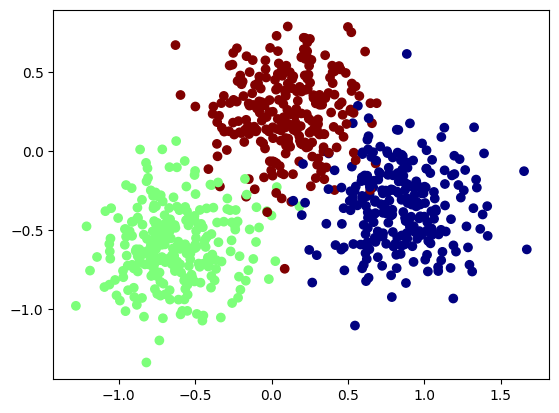

In [40]:
print("train set")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="jet")
plt.show()

test set


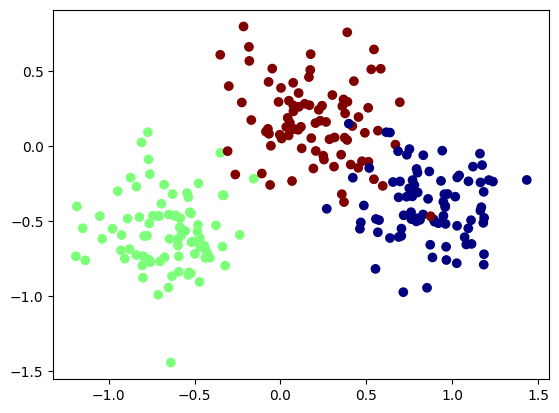

In [41]:
print("test set")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="jet")
plt.show()

# Entrenamiento

In [42]:
def stochastic_gradient_descent(model, X, Y, lr, batch_size, num_classes):
    analytical_weights_grad, analytical_biases_grad = compute_analytical_gradient(model, X, Y, batch_size, num_classes)

    running_loss = 0
    for x, y in zip(X, Y):
        # one hot encode labels
        x = x.reshape(1, -1)
        y = y.reshape(1)
        y_one_hot = one_hot_encode(y, num_classes)

        # feed forward
        y_hat = model.forward(x, grad=True)

        # compute loss and its derivative
        loss = mse(y_hat, y_one_hot)
        d_error = d_mse(y_hat, y_one_hot)
        running_loss += loss

        # backpropagate the error (update gradients)
        model.backward(d_error)

        # gradient descent step
        for i in range(len(model.weights)):
            # update weights
            model.weights[i] += lr * -analytical_weights_grad[i]
            model.biases[i] += lr * -analytical_biases_grad[i]

            # reset gradients
            # model.weights_grad[i].fill(0)
            # model.biases_grad[i].fill(0)

    return running_loss / len(X)

In [43]:
# De manera numérica...
def stochastic_numerical_gradient_descent(model, X, Y, lr, batch_size, num_classes):
    numerical_weights_grad, numerical_biases_grad = compute_numerical_gradient(
        model, X, Y, batch_size=batch_size, num_classes=num_classes
    )
    for l in range(len(model.weights)):
        model.weights[l] += lr * -numerical_weights_grad[l]
        model.biases[l] += lr * -numerical_biases_grad[l]

    loss = 0
    batches = list(zip(X, Y))
    for i in range(0, len(batches), batch_size):
        batch = batches[i : i + batch_size]
        x, y = zip(*batch)
        x = np.array(x)
        y = np.array(y)
        y_one_hot = one_hot_encode(y, num_classes)
        y_hat = model.forward(x)
        loss += mse(y_hat, y_one_hot) * len(x)
    loss /= len(X)

    return loss

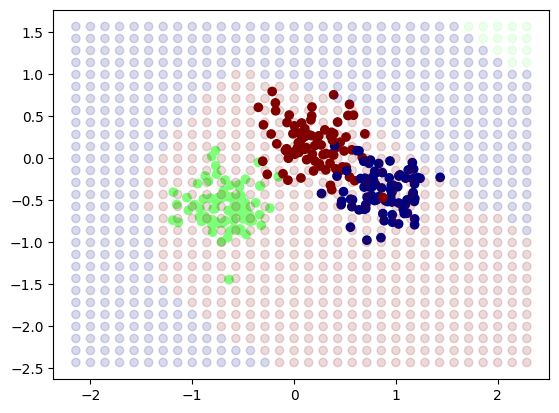

Accuracy on Train Set: 0.336
Accuracy on Test Set: 0.324


In [63]:
model = NeuralNetwork(2, [5], 3)

area_map_set = generate_area_map(X_test, points_per_int = 7)
area_map_plot(model, area_map_set, X_test, y_test, alpha = 0.15)

print("Accuracy on Train Set:", np.mean(model.predict(X_train) == y_train))
print("Accuracy on Test Set:", np.mean(model.predict(X_test) == y_test))

In [64]:
loss_history = []
acc_history = []

for epoch in range(100):
    loss = stochastic_gradient_descent(model, X_train, y_train, lr=0.01, batch_size=1 ,num_classes=3)
    acc = np.mean(model.predict(X_test) == y_test)
    loss_history.append(loss)
    acc_history.append(acc)
    if epoch % 10 == 0:
        print(f"epoch: {epoch:<6} loss: {loss:.6f}     accuracy: {acc:.4f}")

epoch: 0      loss: 0.368462     accuracy: 0.3280
epoch: 10     loss: 0.048098     accuracy: 0.9320
epoch: 20     loss: 0.025621     accuracy: 0.9400
epoch: 30     loss: 0.021161     accuracy: 0.9440
epoch: 40     loss: 0.019287     accuracy: 0.9440
epoch: 50     loss: 0.018249     accuracy: 0.9440
epoch: 60     loss: 0.017599     accuracy: 0.9440
epoch: 70     loss: 0.017149     accuracy: 0.9440
epoch: 80     loss: 0.016812     accuracy: 0.9440
epoch: 90     loss: 0.016550     accuracy: 0.9440


# Results

Text(0.5, 1.0, 'loss')

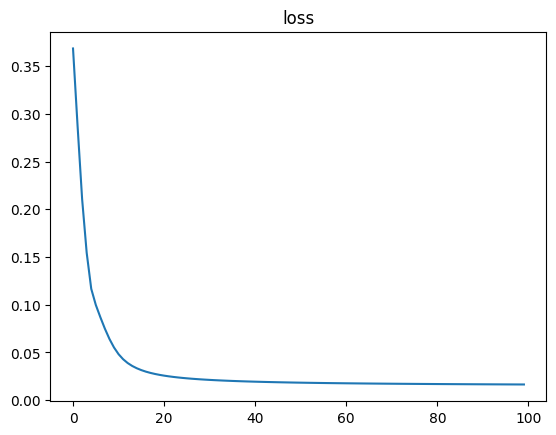

In [65]:
plt.plot(loss_history)
plt.title("loss")

Text(0.5, 1.0, 'accuracy')

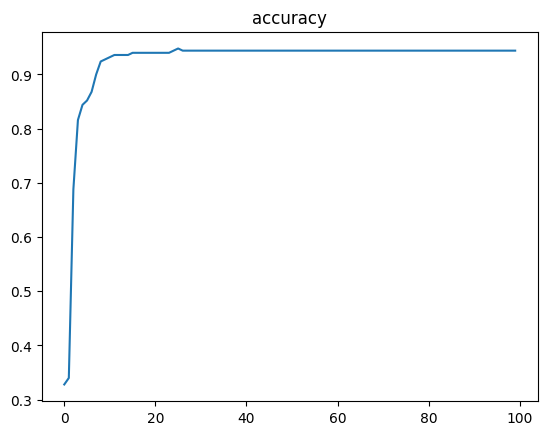

In [66]:
plt.plot(acc_history)
plt.title("accuracy")

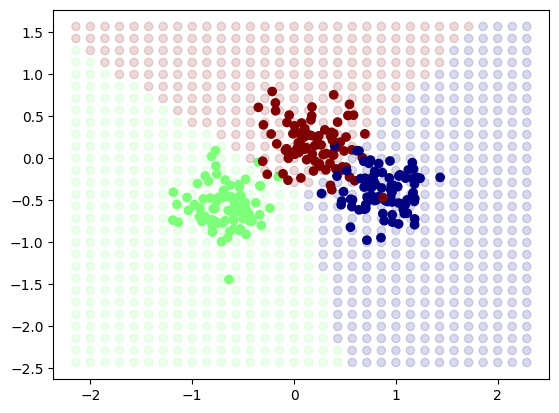

Accuracy on Train Set: 0.972
Accuracy on Test Set: 0.944


In [67]:
area_map_set = generate_area_map(X_test, points_per_int = 7)
area_map_plot(model, area_map_set, X_test, y_test, alpha = 0.15)

print("Accuracy on Train Set:", np.mean(model.predict(X_train) == y_train))
print("Accuracy on Test Set:", np.mean(model.predict(X_test) == y_test))

In [49]:
model.predict(X_test)

array([2, 1, 2, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0,
       2, 2, 2, 0, 1, 2, 2, 1, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 1,
       0, 2, 2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 1, 0, 0, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0,
       1, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2,
       1, 1, 0, 2, 2, 2, 0, 2, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 1, 1, 2, 2,
       0, 2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2,
       1, 2, 0, 2, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0,
       1, 2, 2, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 1,
       0, 0, 0, 1, 1, 2, 0, 0])

In [50]:
y_test == model.predict(X_test)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,